In [192]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [193]:
df = pd.read_csv('/content/loan.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [194]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [195]:
df.describe()


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [196]:
print("Missing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())


Missing values:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Duplicate rows: 0


In [197]:


# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Fill numeric columns with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].median)

# Confirm no missing values remain
print("Missing values after replacement:\n", df.isnull().sum().sort_values(ascending=False))


Missing values after replacement:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [198]:
# Drop Loan_ID (not useful for correlation)
df = df.drop(columns=['Loan_ID'])

# Convert categorical columns to numeric using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Drop rows with missing values (or impute)
df_encoded = df_encoded.dropna()

# Compute correlation matrix
corr_matrix = df_encoded.corr()

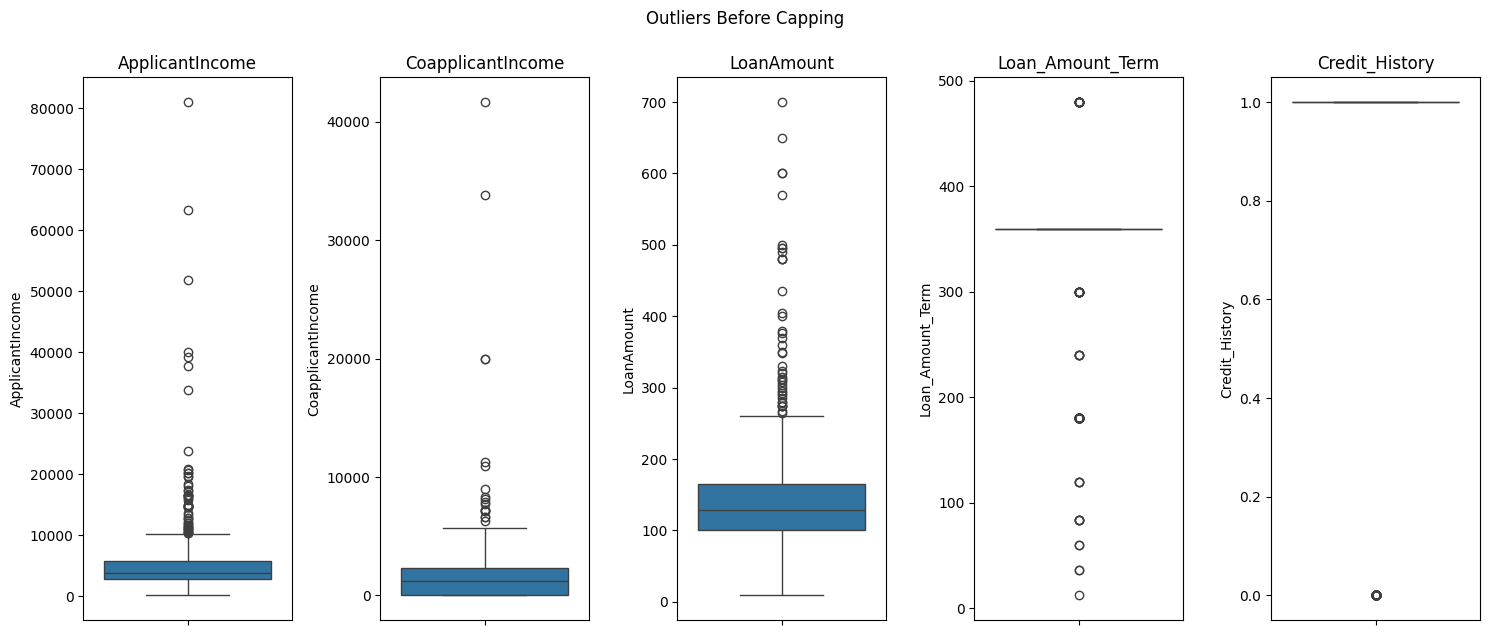

In [199]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(15, 6))
for i, col in enumerate(numeric_cols[:5]):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle("Outliers Before Capping", y=1.05)
plt.show()


In [200]:
# Outlier capping
df_capped = df.copy()

for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df_capped[col] = np.clip(df[col], lower, upper)


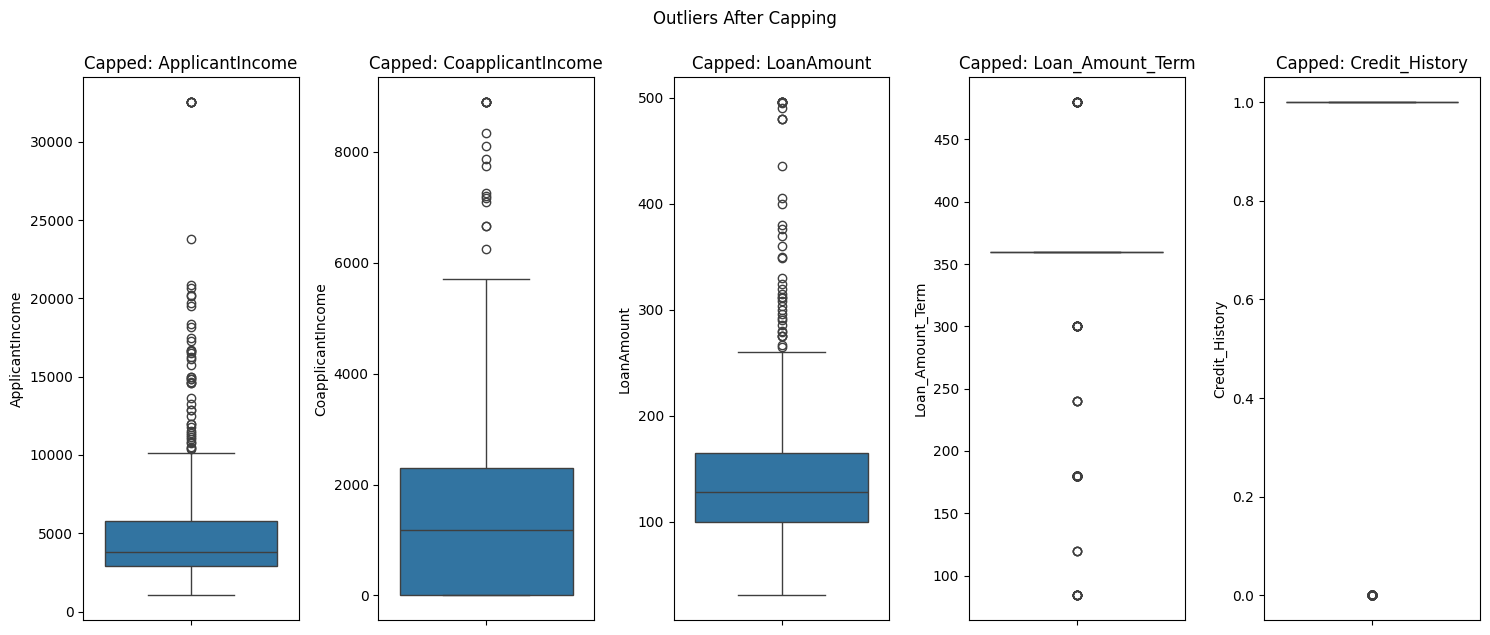

In [201]:
plt.figure(figsize=(15, 6))
for i, col in enumerate(numeric_cols[:5]):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df_capped[col])
    plt.title(f'Capped: {col}')
plt.tight_layout()
plt.suptitle("Outliers After Capping", y=1.05)
plt.show()


In [202]:

target_column = 'Loan_Status'

# Encode categorical target
df_capped[target_column] = LabelEncoder().fit_transform(df_capped[target_column])

In [203]:
df_capped = df_capped.dropna()

In [204]:
X = df_capped.drop(columns=target_column)
y = df_capped[target_column]

In [205]:

# Encode any categorical features
X = pd.get_dummies(X, drop_first=True)

In [206]:
# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

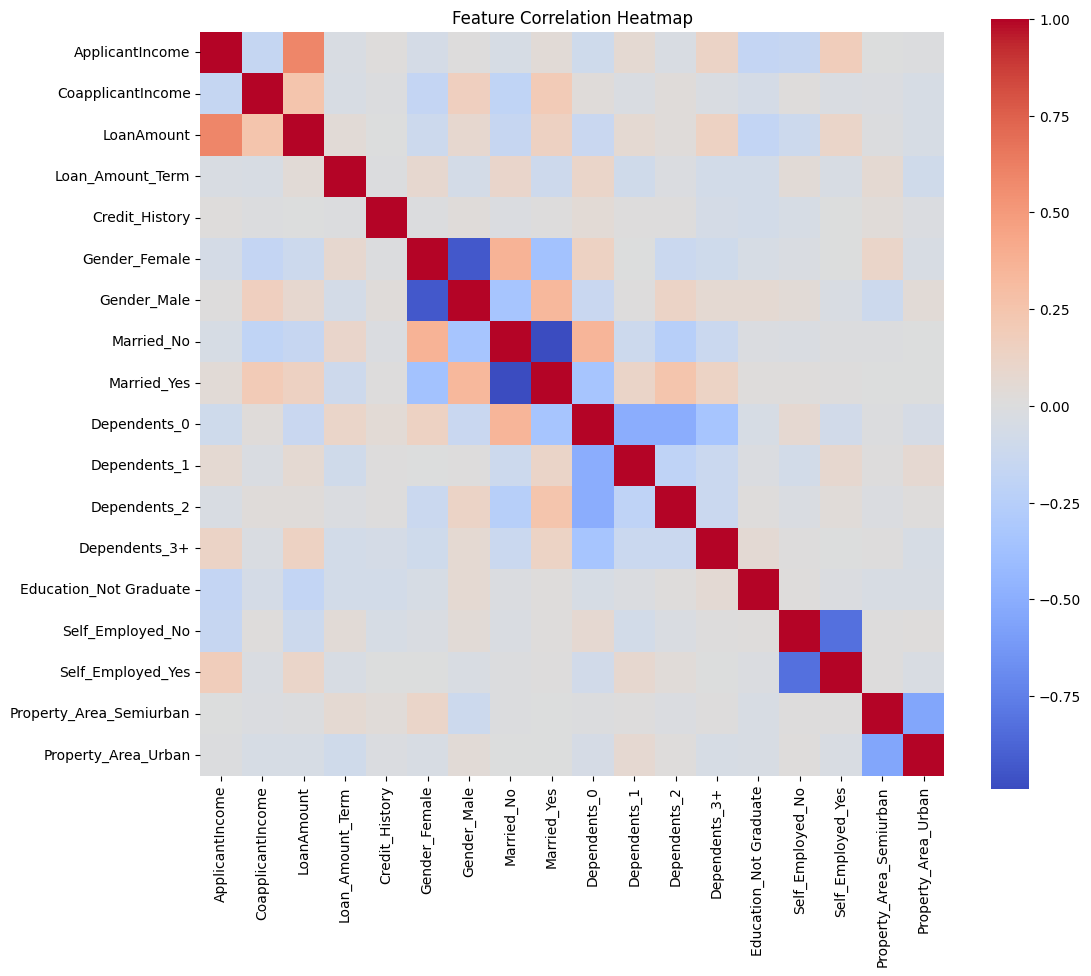

In [207]:
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()


In [208]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [209]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000]
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)
print("Test Accuracy with Best Model:", accuracy_score(y_test, grid.best_estimator_.predict(X_test)))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}
Best CV Accuracy: 0.8166357452071737
Test Accuracy with Best Model: 0.7886178861788617


In [210]:


model = LogisticRegression(max_iter=1000, penalty='l2', C=10   )
model.fit(X_train, y_train)

print("Train Accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, model.predict(X_test)))


Train Accuracy: 0.8167006109979633
Test Accuracy: 0.7886178861788617


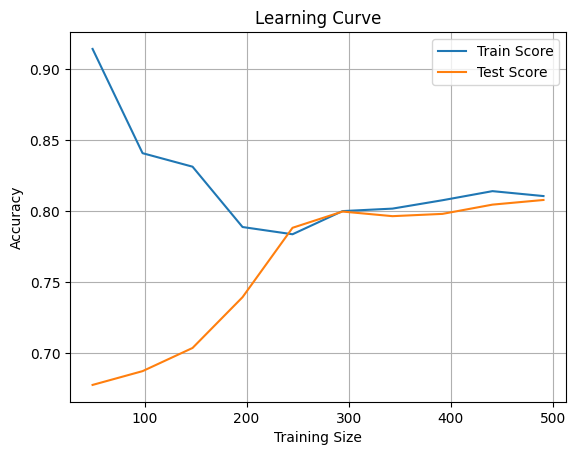

In [211]:
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Score')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



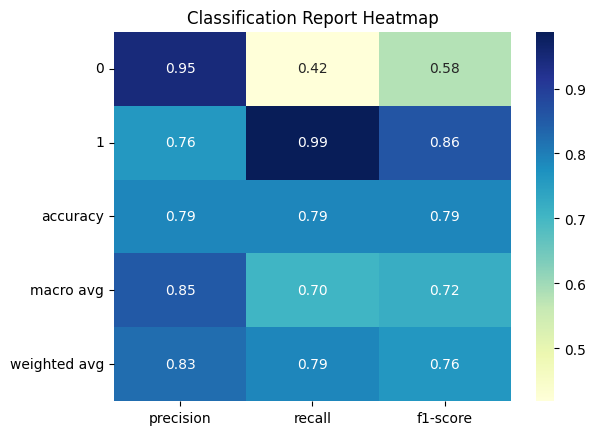

In [212]:
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


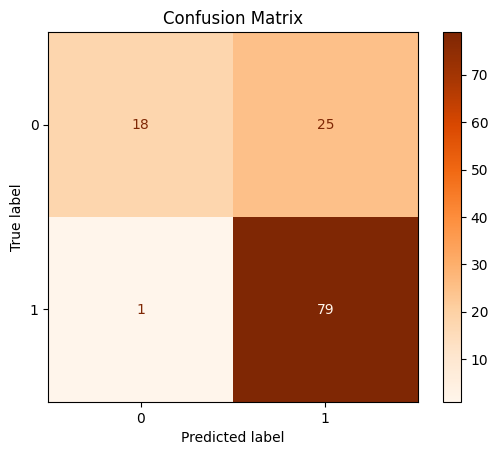

In [213]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Oranges')
plt.title("Confusion Matrix")
plt.show()


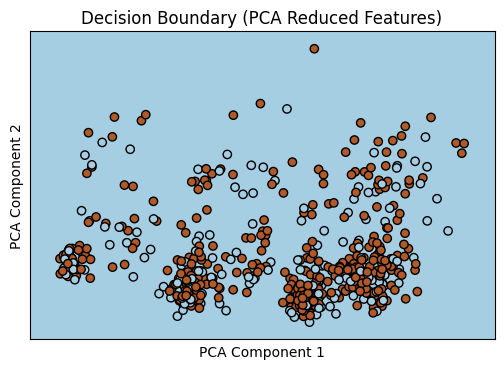

In [214]:
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

# Reduce features to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train logistic regression on PCA-transformed data
logreg_pca = LogisticRegression(C=1, max_iter=1000)
logreg_pca.fit(X_pca, y)

# Plot decision boundary
_, ax = plt.subplots(figsize=(6, 4))
DecisionBoundaryDisplay.from_estimator(
    logreg_pca,
    X_pca,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="PCA Component 1",
    ylabel="PCA Component 2",
    eps=0.5,
)

# Overlay the training points
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)
plt.title("Decision Boundary (PCA Reduced Features)")
plt.xticks(())
plt.yticks(())
plt.show()


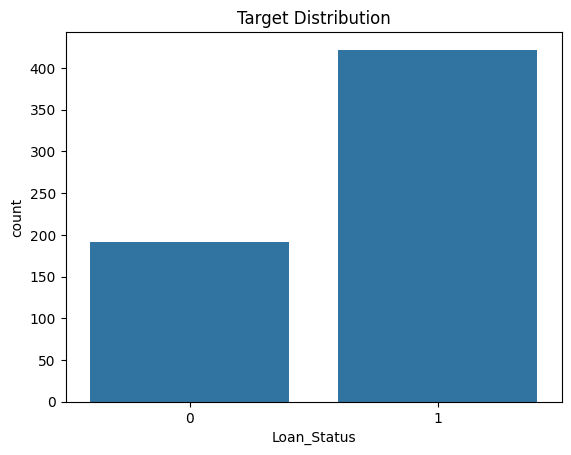

In [215]:
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()


In [216]:
from sklearn.svm import SVC



In [217]:


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [218]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
print("Best Parameters:", grid.best_params_)
print("Train Accuracy:", accuracy_score(y_train, best_svm.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, best_svm.predict(X_test)))


Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Train Accuracy: 0.814663951120163
Test Accuracy: 0.7886178861788617


In [224]:

manual_svm = SVC(C=1, kernel='rbf', gamma=0.01)
manual_svm.fit(X_train, y_train)


y_pred_svm = manual_svm.predict(X_test)
print(" SVM Train Accuracy:", accuracy_score(y_train, manual_svm.predict(X_train)))
print(" SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))


 SVM Train Accuracy: 0.814663951120163
 SVM Test Accuracy: 0.7886178861788617


In [220]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.65      1.00      0.79        80

    accuracy                           0.65       123
   macro avg       0.33      0.50      0.39       123
weighted avg       0.42      0.65      0.51       123



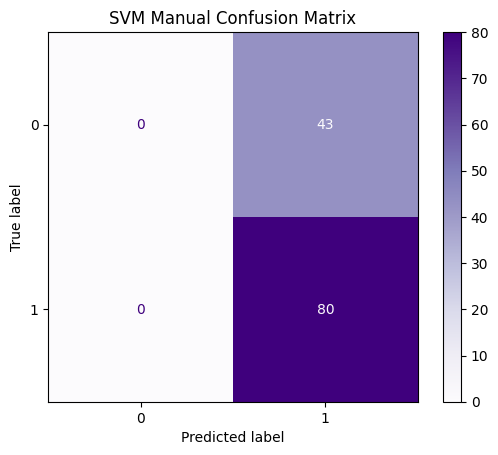

In [221]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("SVM Manual Confusion Matrix")
plt.show()


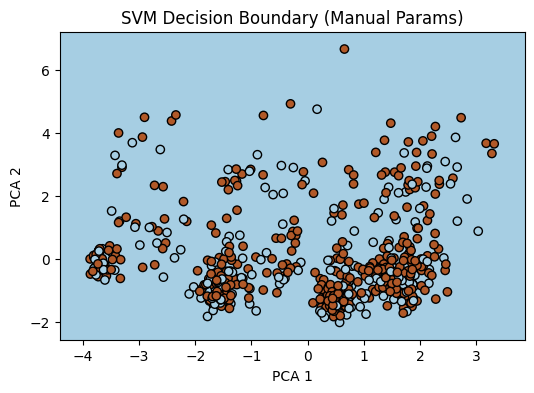

In [222]:


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

svm_2d = SVC(kernel='rbf', C=10, gamma='scale')
svm_2d.fit(X_pca, y)

_, ax = plt.subplots(figsize=(6, 4))
DecisionBoundaryDisplay.from_estimator(
    svm_2d,
    X_pca,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="PCA 1",
    ylabel="PCA 2",
    eps=0.5,
)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)
plt.title("SVM Decision Boundary (Manual Params)")
plt.show()
